# Description
This notebook conducts an experiment based on the targeted harmful object removal experiment from the paper (Section 4.5, B). The goal of the experiment is to check whether Influence Functions for GBDT provides a reliable way of "targeting" a particular difficult test object $\mathbf{x_{test}}$ and identifying training objects $\mathbf{x_{train}}$ "harmul" specifically for the test object at hand.

The plan of the experiment is as follows:
- Read train/test data, introduce noise into the train set
- Calculate two "scores" prioritizing points to remove:
    - **LeafInfluence**: Derivative of the Logloss on $\mathbf{x_{test}}$ w.r.t. the weight of $\mathbf{x_{train}}$: $\frac{\partial L(y_{test}, F(x_{test}, \mathbf{w})}{\partial w_{\mathbf{x_{train}}}}$
    - **Detector**: Prediction of the model (trained on noisy data) w.r.t. to the opposite class. This is a noise detection method that is unable to target specific test points.
- Iteratively remove training points from the train set and measure how the Logloss changes on $\mathbf{x_{test}}$.

# Imports

In [1]:
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../influence_boosting')

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import log_loss
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy
from catboost import CatBoostClassifier
from ipywidgets import IntProgress

from data.adult import read_train_documents_and_one_hot_targets
from util import read_json_params, export_catboost_to_json
from influence_boosting.influence.leaf_influence import CBLeafInfluenceEnsemble

# Reading and preparing data
First, we read our train and test datasets:

In [2]:
train_data, train_targets = read_train_documents_and_one_hot_targets('../data/adult/train_data_catboost_format.tsv')
train_targets = np.argmax(train_targets, axis=1)
test_data, test_targets = read_train_documents_and_one_hot_targets('../data/adult/test_data_catboost_format.tsv')
test_targets = np.argmax(test_targets, axis=1)

We then inject random noise into training labels:

In [3]:
def make_nonuniform_noisy_sample(targets, flip_frac, p=None, seed=10):
    """
    Choose int(len(targets) * flip_frac) points for flipping. Probability of flipping is proportional to p.
    """
    if seed is not None:
        np.random.seed(seed)
    if p is None:
        p = np.ones(len(targets))
    p /= np.sum(p)
    perturbed_idxs = np.random.choice(len(targets), size=int(len(targets) * flip_frac), replace=False, p=p)
    result = deepcopy(targets)
    perturbed_idxs_mask = np.zeros_like(targets)
    for perturbed_i in perturbed_idxs:
        result[perturbed_i] = 1 - result[perturbed_i]
        perturbed_idxs_mask[perturbed_i] = 1
    return result, perturbed_idxs_mask

np.random.seed(20)
frac = 4000 / float(len(train_targets))
train_targets_polluted, polluted_gt = make_nonuniform_noisy_sample(train_targets, frac, seed=None)

# Obtain scores
We now fix a particular test index that we would like to target and calculate the "scores" of the train points w.r.t. this test point.

In [4]:
test_idx = 899

Temporary training directory:

In [5]:
train_dir = '../data/adult/catboost_tmp_dir'
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

Read CatBoost parameters and train the model on the noisy data:

In [6]:
catboost_params = read_json_params('../data/adult/catboost_params.json')
catboost_params['train_dir'] = train_dir
catboost_params['random_seed'] = 10
cbc = CatBoostClassifier(**catboost_params)
cbc.fit(train_data, train_targets_polluted)

Save the model, export it to JSON and create a ``CBLeafInfluenceEnsemble`` using this JSON. We will use the smallest Update Set (see Section 3.1.2 of the paper) to save time.

In [7]:
cbc.save_model(train_dir + '/model.bin')
export_catboost_to_json(train_dir + '/model.bin', train_dir + '/model.json')
leafinfluence = CBLeafInfluenceEnsemble(train_dir + '/model.json', train_data, train_targets_polluted,
                                        leaf_method=catboost_params['leaf_estimation_method'],
                                        learning_rate=catboost_params['learning_rate'],
                                        update_set='SinglePoint')

Calculate loss derivatives (**LeafInfluence**):

In [ ]:
influence_scores = []
buf = deepcopy(leafinfluence)
for i in tqdm_notebook(xrange(len(train_data))):
    leafinfluence.fit(removed_point_idx=i, destination_model=buf)
    influence_scores.append(buf.loss_derivative(test_data[[test_idx]], test_targets[[test_idx]])[0])
influence_scores = np.array(influence_scores)

Calculate **Detector** scores:

In [9]:
detector_scores = cbc.predict_proba(train_data)[xrange(len(train_data)), 1 - train_targets_polluted]

# Measure loss reductions
We proceed to iteratively remove train points according to the obtained scores and measure how this affects the losses on ``test_idx``.

Utility functions:

In [10]:
def catboost_fit_predict(train_documents, train_targets, test_documents, prediction_type='RawFormulaVal',
                         **catboost_params):
    if 'gpu_ram_part' in catboost_params:
        gpu_ram_part = catboost_params.pop('gpu_ram_part')
    else:
        gpu_ram_part = None
    cbc = CatBoostClassifier(**catboost_params)
    if gpu_ram_part is not None:
        cbc.set_params(gpu_ram_part=gpu_ram_part)
    cbc.fit(train_documents, train_targets)
    return cbc.predict(test_documents, prediction_type)

def prediction_fidelity_after_iterative_fixing(train_documents, train_targets, test_documents, test_targets, test_idx,
                                               scores, batch_size, max_steps, **catboost_params):
    prediction_original = catboost_fit_predict(train_documents, train_targets, test_documents,
                                               'Probability', **catboost_params)
    loss_on_test_idx_original = log_loss(y_true=test_targets[[test_idx]], y_pred=prediction_original[[test_idx]],
                                        labels=[0, 1])
    
    losses_on_test_idx = []
    batch_num = 0
    harmful_idxs_queue = np.argsort(-scores)
    idxs_to_remove = []
    pbar = tqdm_notebook(total=max_steps + 1)
    while len(train_documents) - len(idxs_to_remove) > batch_size and batch_num < max_steps + 1:
        first_new_removed_idx = (batch_num - 1) * batch_size
        idxs_to_remove_batch = harmful_idxs_queue[first_new_removed_idx:first_new_removed_idx + batch_size]
        idxs_to_remove += list(idxs_to_remove_batch)
        train_documents_reduced = np.delete(train_documents, idxs_to_remove, axis=0)
        train_targets_reduced = np.delete(train_targets, idxs_to_remove, axis=0)
        prediction = catboost_fit_predict(train_documents_reduced, train_targets_reduced, test_documents,
                                          'Probability', **catboost_params)
        loss_on_test_idx = log_loss(y_true=test_targets[[test_idx]], y_pred=prediction[[test_idx]], labels=[0, 1])
        losses_on_test_idx.append((loss_on_test_idx - loss_on_test_idx_original) / loss_on_test_idx_original)
        batch_num += 1
        pbar.update(1)
    pbar.close()
    return losses_on_test_idx

Run calculations:

In [ ]:
losses_on_test_idx_for_scores = {}
losses_on_test_idx_for_scores['LeafInfluence'] = prediction_fidelity_after_iterative_fixing(
    train_data, train_targets_polluted, test_data, test_targets, test_idx, influence_scores, 50, 80, **catboost_params
)
losses_on_test_idx_for_scores['Detector'] = prediction_fidelity_after_iterative_fixing(
    train_data, train_targets_polluted, test_data, test_targets, test_idx, detector_scores, 50, 80, **catboost_params
)

Plot the results:

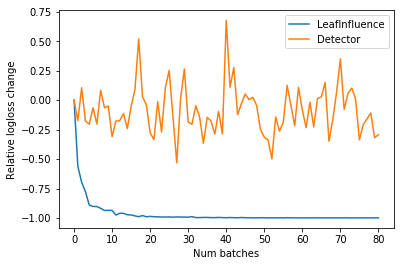

In [12]:
for name in losses_on_test_idx_for_scores:
    plt.plot(losses_on_test_idx_for_scores[name], label=name)
plt.xlabel('Num batches')
plt.ylabel('Relative logloss change')
plt.legend()
plt.show()

Although, as demonstrated in Section 4.5, A, **Detector** is a slightly stronger noise detector "on average", this plot demonstrates that **LeafInfluence** greatly outperforms it in targeting training objects harmful for the specific $\mathbf{x_{test}}$.